## Resolution notebook for MACS users - Use colab button for interactivity.
Adjust the lattice parameters and sample orientation based on your needs, a false sample in the laboratory frame is used as an example. 

In [1]:
!pip install -q git+https://github.com/thallor1/pyMACS.git requests

In [2]:
import numpy as np
import pyMACS

In [3]:
# Here, a false sample in the laboratory frame default. Update with your lattice parameters below.
# The false sample has lattice parameters such that H, K, L are in units of inverse angstrom. 
# i.e. H=1, K=1 is the same as Qx=1 \AA^{-1}, Qz=1 \AA^{-1}
a,b,c = 2.0*np.pi, 2.0*np.pi, 2.0*np.pi
alpha,beta,gamma = 90.0,90.0,90.0
u_vec = [1,0,0]
v_vec = [0,1,0]

# Macs final energy is required here:
macsEf = 5.0

In [4]:
#Set up our pyMACS object

from pyMACS.virtualMACS import VirtualMACS
import pyMACS
import numpy as np

macs_instr = VirtualMACS('resolution',cifName=None,useOld=True)
macs_instr.sample.formula_weight=432.7
macs_instr.sample.a = a
macs_instr.sample.b = b
macs_instr.sample.c = c
macs_instr.sample.alpha = alpha
macs_instr.sample.beta = beta
macs_instr.sample.gamma = gamma

macs_instr.sample.orient_u = u_vec
macs_instr.sample.orient_v = v_vec
macs_instr.sample.project_sample_realspace()
macs_instr.kidney.Ef=macsEf

# Option 1: Resolution matrix for specific H, K, L, $\Delta$E

This function pulls from a tabulated list of pre-calculated ellipsoids. The results will never be as good as a full simulation; if a width seems strange, it likely means that the ellipsoid was not generated correctly. 


 Qx, Qz, for hkl = [-1.00003, -1.00003]
Covariance matrix in lab system:
[[ 0.00123123 -0.0007835   0.00431767]
 [-0.0007835   0.00170764 -0.00145206]
 [ 0.00431767 -0.00145206  0.03394656]]

Resolution matrix in lab system:
[[2154.46756618  784.01566905 -240.49098004]
 [ 784.01566905  893.0110895   -61.52070585]
 [-240.49098004  -61.52070585   57.41462014]]

Transformation into (Qpara, Qperp, E) system:
[[ 0.70710678 -0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]

Mean (Q, E) vector in (Qpara, Qperp, Qup, E) system:
[1.50477994e-16 1.30696000e+00 1.00000000e+00]

Covariance matrix in (Qpara, Qperp, E) system:
[[ 0.00225294  0.00023821  0.00407981]
 [ 0.00023821  0.00068593 -0.00202629]
 [ 0.00407981 -0.00202629  0.03394656]]

Resolution matrix in (Qpara, Qperp, E) system:
[[ 739.72365879 -630.72823834 -126.55109451]
 [-630.72823834 2307.75499689  213.55451109]
 [-126.55109451  213.55451109   57.41462014]]

3d resolution ellipso

/home/tjh/mambaforge/envs/mantid/lib/python3.10/site-packages/pyMACS/scripting/resfunc.py:588: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


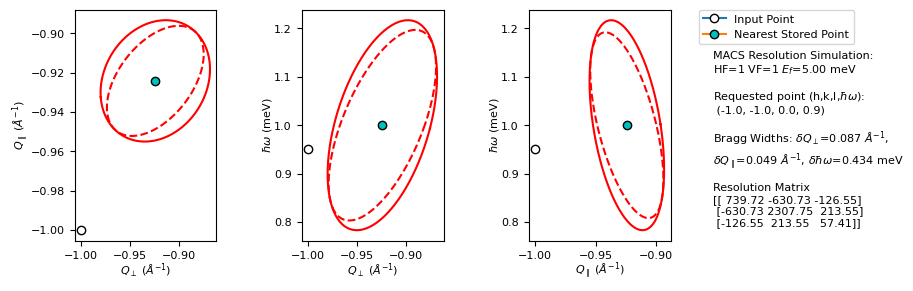

In [5]:
# A warning will be thrown if the given HKL point is out of the scattering plane, but the script will attempt to project 
# the result onto the scattering plane. 
h = -1.0
k = -1.0
l = 0.0
E = 1.0 #energy transfer, i.e. Ei=6 meV
M,M_fwhms,Q_hkw = pyMACS.scripting.macs_resfunc(h,k,l,E,macsEf,macs_instr,gen_plot=True,verbose=True,calc_mode='load_cov')

# Option 2 : Plot multiple resolution ellipsoids in the scattering plane at constant energy.

Most of the code here is used to project the ellipsoids : Users only need to concern themselves with the first few lines. 

In [6]:
from pyMACS import scripting
import numpy.linalg as la
from pyMACS.virtualMACS import VirtualMACS
import matplotlib.pyplot as plt

#Adjust this as needed. 
hpts = np.linspace(0.2,1.5,8)
kpts = np.linspace(0.2,1.5,8)
H,K = np.meshgrid(hpts,kpts)
hpts = H.flatten()
kpts = K.flatten()
lpts = np.zeros(len(hpts))
deltaE = 2.0
Ef=5.0

/tmp/ipykernel_208522/1738536076.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


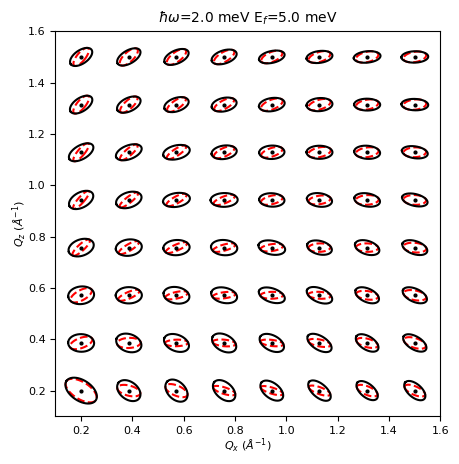

In [7]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
qx_pt_list = []
qz_pt_list = []
for i,hpt in enumerate(hpts):
    qvec = hpts[i]*macs_instr.sample.astar_vec_labframe+\
            kpts[i]*macs_instr.sample.bstar_vec_labframe+\
            lpts[i]*macs_instr.sample.cstar_vec_labframe
    qxpt,qzpt = macs_instr.sample.HKL_to_QxQz(qvec[0],qvec[2],qvec[1])
    M_load,M_diag_load,Q_hkw_load = macs_instr.resmat(qvec[0],qvec[2],qvec[1],deltaE,Ef,
                                                 gen_plot=False,verbose=False)
    # The resolution matrices have been generated for each ellipsoid here - these need to be 
    # projected into the scattering plane, which is done below. 
    
    sig2hwhm = np.sqrt(2. * np.log(2.))
    sig2fwhm = 2.*sig2hwhm
    
    Qmean=np.array([qxpt,qzpt,Q_hkw_load[2]])
    
    results,Qres_proj = scripting.calc_ellipses(M_load,verbose=False)
    
    ellfkt = lambda rad, rot, phi, Qmean2d : \
        np.dot(rot, np.array([ rad[0]*np.cos(phi), rad[1]*np.sin(phi) ])) + Qmean2d
    
    
    # 2d plots
    #fig = plot.figure()
    ellis = results
    num_ellis = len(ellis)
    coord_axes = [[0,1], [1,2], [0,2]]
    coord_axes = [[0,1], [0,2], [1,2]]
    
    ellplots = []
    for ellidx in [0]:
        # centre plots on zero or mean Q vector ?
        QxE = np.array([[0], [0]])
        QxE = np.array([[Qmean[coord_axes[ellidx][0]]], [Qmean[coord_axes[ellidx][1]]]])
    
        phi = np.linspace(0, 2.*np.pi, 361)
    
        ell_QxE = ellfkt(ellis[ellidx]["fwhms"]*0.5, ellis[ellidx]["rot"], phi, QxE)
        ell_QxE_proj = ellfkt(ellis[ellidx]["fwhms_proj"]*0.5, ellis[ellidx]["rot_proj"], phi, QxE)
        ellplots.append({"sliced":ell_QxE, "proj":ell_QxE_proj})
    
        ax.plot(ell_QxE[0], ell_QxE[1], c="r", linestyle="dashed")
        ax.plot(ell_QxE_proj[0], ell_QxE_proj[1], c="k", linestyle="solid")
    ax.plot(qxpt,qzpt,marker='o',mfc='k',mec='k',ms=2)
    qx_pt_list.append(qxpt)
    qz_pt_list.append(qzpt)
ax.set_xlabel(r"$Q_x\ (\AA^{-1}$)",labelpad=0,fontsize=8)
ax.set_ylabel(r"$Q_z\ (\AA^{-1}$)",labelpad=0,fontsize=8)
#Match limits of dave plots
ax.set_aspect(1)
ax.set_xlim(np.nanmin(qx_pt_list)-0.1,np.nanmax(qx_pt_list)+0.1 )
ax.set_ylim(np.nanmin(qz_pt_list)-0.1,np.nanmax(qz_pt_list)+0.1)
ax.set_title(r"$\hbar\omega$="+f"{deltaE:.1f} meV "+r"E$_f$="+f"{Ef:.1f} meV",fontsize=10)
#ax[1].set_aspect(1)
#ax[2].set_aspect(1)


fig.show()

# Option 3 : Get FWHM values of dQx, dQy, dQz for an arbitrary list of $h,k,l,\hbar\omega$

Uses pre-built interpolator objects, as shown below.

In [8]:
#Adjust this as needed. 
H1,K1,L1 = 1.0,1.0,0.0
macsEf = 3.7
omegas = np.linspace(0,10,50)
macs_instr.kidney.Ef=macsEf
interp_dQx, interp_dQz, interp_dE = macs_instr.load_res_fwhm_interp_objects()
#These interpolators require input in terms of lab fram, not H,K,L. This is done in the following way.
qx1,qz1 = macs_instr.sample.HKL_to_QxQz(H1,K1,L1)

#Now call the interpolators:
Efwhms1 = []
Efwhms2 = []
for i,dE in enumerate(omegas):
    dE_fwhm1 = interp_dE([qx1,qz1,dE])
    print(f"{dE:.4f} {dE_fwhm1[0]:.4f}")
    Efwhms1.append(dE_fwhm1)

fig,ax = plt.subplots(1,1)
ax.plot(omegas,Efwhms1,color='k',ls='-',label=f"h={H1:.2f},k={K1:.2f},l={L1:.2f}")
#ax.plot(omegas,Efwhms2,color='b',ls='-',label=f"h={H2:.2f},k={K2:.2f},l={L2:.2f}")
ax.set_xlabel(r"$\hbar\omega$ (meV)")
ax.set_ylabel(r"$\delta E_{FWHM}$ (meV)")
ax.set_title(f"Energy Resolution at [{H1:.2f},{K1:.2f},{L1:.2f}] point, MACS Ef={macsEf}",fontsize=10)



FileNotFoundError: [Errno 2] No such file or directory: '/home/tjh/mambaforge/envs/mantid/lib/python3.10/site-packages/pyMACS/scripting/MACS_Ef_3p7_interp_dQx.pck'